<a href="https://colab.research.google.com/github/globalit6679/MSc-Project/blob/main/MSc_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## JAAD 데이터셋

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Interface for the JAAD dataset:

A. Rasouli, I. Kotseruba, and J. K. Tsotsos,“Are they going to cross?
a benchmark dataset and baseline for pedestrian crosswalk behavior,” In Proc.
ICCV Workshop, 2017, pp. 206–213.

A. Rasouli, I. Kotseruba, and J. K. Tsotsos, “Agreeing to cross: How drivers
and pedestrians communicate,” In Proc. Intelligent Vehicles Symposium (IV),
2017, pp. 264–269.

I. Kotseruba, A. Rasouli, and J. K. Tsotsos, “Joint attention in autonomous
 driving (jaad),” arXiv:1609.04741, 2016.

MIT License

Copyright (c) 2018 I. Kotseruba

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

"""
import sys
import pickle
import cv2

import numpy as np
import xml.etree.ElementTree as ET

from os.path import join, abspath, exists
from os import listdir, makedirs
from sklearn.model_selection import train_test_split, KFold


class JAAD(object):
    def __init__(self, data_path='', regen_pkl=False):
        """
        Constructor of the jaad class
        :param data_path: Path to the folder of the dataset
        :param regen_pkl: Whether to regenerate the database
        """
        self._year = '2016'
        self._name = 'JAAD'
        self._regen_pkl = regen_pkl
        self._image_ext = '.png'

        # Paths
        self._jaad_path = data_path if data_path else self._get_default_path()
        assert exists(self._jaad_path), \
            'Jaad path does not exist: {}'.format(self._jaad_path)
        self._data_split_ids_path = join(self._jaad_path, 'split_ids')
        self._annotation_path = join(self._jaad_path, 'annotations')
        # self._annotation_vehicle_path = join(self._jaad_path, 'annotations_vehicle')
        # self._annotation_traffic_path = join(self._jaad_path, 'annotations_traffic')
        # self._annotation_attributes_path = join(self._jaad_path, 'annotations_attributes')
        # self._annotation_appearance_path = join(self._jaad_path, 'annotations_appearance')
        self._clips_path = join(self._jaad_path, 'videos')
        self._images_path = join(self._jaad_path, 'images')

    # Path generators
    @property
    def cache_path(self):
        """
        Generate a path to save cache files
        :return: Cache file folder path
        """
        cache_path = abspath(join(self._jaad_path, 'data_cache'))
        if not exists(cache_path):
            makedirs(cache_path)
        return cache_path

    def _get_default_path(self):
        """
        Return the default path where jaad_raw files are expected to be placed.
        :return: the default path to the dataset folder
        """
        return '/content/'

    def _get_video_ids_split(self, image_set, subset='default'):
        """
        Returns a list of video ids for a given data split
        :param image_set: Data split, train, test, val
        :return: The list of video ids
        """
        vid_ids = []
        sets = [image_set] if image_set != 'all' else ['train', 'test', 'val']
        for s in sets:
            vid_id_file = join(self._data_split_ids_path, subset, s + '.txt')
            with open(vid_id_file, 'rt') as fid:
                vid_ids.extend([x.strip() for x in fid.readlines()])
        return vid_ids

    def _get_video_ids(self):
        """
        Returns a list of all video ids
        :return: The list of video ids
        """
        return [vid.split('.')[0] for vid in listdir(self._annotation_path)]

    def _get_image_path(self, vid, fid):
        """
          Generates the image path given ids
          :param vid: Video id
          :param fid: Frame id
          :return: Return the path to the given image
          """
        return join(self._images_path, vid,
                    '{:05d}.png'.format(fid))

    # Visual helpers
    def update_progress(self, progress):
        """
         Creates a progress bar
         :param progress: The progress thus far
         """
        barLength = 20
        status = ""
        if isinstance(progress, int):
            progress = float(progress)

        block = int(round(barLength * progress))
        text = "\r[{}] {:0.2f}% {}".format("#" * block + "-" * (barLength - block), progress * 100, status)
        sys.stdout.write(text)
        sys.stdout.flush()

    def _print_dict(self, dic):
        """
         Prints a dictionary, one key-value pair per line
         :param dic: Dictionary
         """
        for k, v in dic.items():
            print('%s: %s' % (str(k), str(v)))

    # Image processing helpers
    def _squarify(self, bbox, ratio, img_width):
        """
        Changes is the ratio of bounding boxes to a fixed ratio
        :param bbox: Bounding box
        :param ratio: Ratio to be changed to
        :param img_width: Image width
        :return: Squarified boduning box
        """
        width = abs(bbox[0] - bbox[2])
        height = abs(bbox[1] - bbox[3])
        width_change = height * ratio - width

        bbox[0] = bbox[0] - width_change / 2
        bbox[2] = bbox[2] + width_change / 2
        if bbox[0] < 0:
            bbox[0] = 0

        # check whether the new bounding box goes beyond image boarders
        # If this is the case, the bounding box is shifted back
        if bbox[2] > img_width:
            bbox[0] = bbox[0] - bbox[2] + img_width
            bbox[2] = img_width
        return bbox

    def extract_and_save_images(self):
        """
        Extract images from clips and save on drive
        """

        videos = [f.split('.')[0] for f in sorted(listdir(self._clips_path))]

        for vid in videos:
            path_to_file = join(self._annotation_path, vid + '.xml')
            print(vid)
            tree = ET.parse(path_to_file)
            num_frames = int(tree.find("./meta/task/size").text)

            video_clip_path = join(self._clips_path, vid + '.mp4')

            save_images_path = join(self._images_path, vid)
            if not exists(save_images_path):
                makedirs(save_images_path)

            vidcap = cv2.VideoCapture(video_clip_path)
            success, image = vidcap.read()
            frame_num = 0
            img_count = 0
            if not success:
                print('Failed to open the video {}'.format(vid))
            while success:
                self.update_progress(img_count / num_frames)
                img_count += 1
                if not exists(join(save_images_path, "{:05d}.png").format(frame_num)):
                    cv2.imwrite(join(save_images_path, "{:05d}.png").format(frame_num), image)
                else:
                    print('path %s already exists')
                success, image = vidcap.read()
                frame_num += 1
            if num_frames != img_count:
                print('num images don\'t match {}/{}'.format(num_frames, img_count))
            print('\n')

    # Annotation processing helpers
    def _map_text_to_scalar(self, label_type, value):
        """
        Maps a text label in XML file to scalars
        :param label_type: The label type
        :param value: The text to be mapped
        :return: The scalar value
        """
        map_dic = {'occlusion': {'none': 0, 'part': 1, 'full': 2},
                   'action': {'standing': 0, 'walking': 1},
                   'nod': {'__undefined__': 0, 'nodding': 1},
                   'look': {'not-looking': 0, 'looking': 1},
                   'hand_gesture': {'__undefined__': 0, 'greet': 1, 'yield': 2,
                                    'rightofway': 3, 'other': 4},
                   'reaction': {'__undefined__': 0, 'clear_path': 1, 'speed_up': 2,
                                'slow_down': 3},
                   'cross': {'not-crossing': 0, 'crossing': 1, 'irrelevant': -1},
                   'age': {'child': 0, 'young': 1, 'adult': 2, 'senior': 3},
                   'designated': {'ND': 0, 'D': 1},
                   'gender': {'n/a': 0, 'female': 1, 'male': 2},
                   'intersection': {'no': 0, 'yes': 1},
                   'motion_direction': {'n/a': 0, 'LAT': 1, 'LONG': 2},
                   'traffic_direction': {'OW': 0, 'TW': 1},
                   'signalized': {'n/a': 0, 'NS': 1, 'S': 2},
                   'vehicle': {'stopped': 0, 'moving_slow': 1, 'moving_fast': 2,
                               'decelerating': 3, 'accelerating': 4},
                   'road_type': {'street': 0, 'parking_lot': 1, 'garage': 2},
                   'traffic_light': {'n/a': 0, 'red': 1, 'green': 2}}

        return map_dic[label_type][value]

    def _map_scalar_to_text(self, label_type, value):
        """
        Maps a scalar value to a text label
        :param label_type: The label type
        :param value: The scalar to be mapped
        :return: The text label
        """
        map_dic = {'occlusion': {0: 'none', 1: 'part', 2: 'full'},
                   'action': {0: 'standing', 1: 'walking'},
                   'nod': {0: '__undefined__', 1: 'nodding'},
                   'look': {0: 'not-looking', 1: 'looking'},
                   'hand_gesture': {0: '__undefined__', 1: 'greet',
                                    2: 'yield', 3: 'rightofway',
                                    4: 'other'},
                   'reaction': {0: '__undefined__', 1: 'clear_path',
                                2: 'speed_up', 3: 'slow_down'},
                   'cross': {0: 'not-crossing', 1: 'crossing', -1: 'irrelevant'},
                   'age': {0: 'child', 1: 'young', 2: 'adult', 3: 'senior'},
                   'designated': {0: 'ND', 1: 'D'},
                   'gender': {0: 'n/a', 1: 'female', 2: 'male'},
                   'intersection': {0: 'no', 1: 'yes'},
                   'motion_direction': {0: 'n/a', 1: 'LAT', 2: 'LONG'},
                   'traffic_direction': {0: 'OW', 1: 'TW'},
                   'signalized': {0: 'n/a', 1: 'NS', 2: 'S'},
                   'vehicle': {0: 'stopped', 1: 'moving_slow', 2: 'moving_fast',
                               3: 'decelerating', 4: 'accelerating'},
                   'road_type': {0: 'street', 1: 'parking_lot', 2: 'garage'},
                   'traffic_light': {0: 'n/a', 1: 'red', 2: 'green'}}

        return map_dic[label_type][value]

    def _get_annotations(self, vid):
        """
        Generates a dictinary of annotations by parsing the video XML file
        :param vid: The id of video to parse
        :return: A dictionary of annotations
        """
        path_to_file = join(self._annotation_path, vid + '.xml')
        tree = ET.parse(path_to_file)
        ped_annt = 'ped_annotations'

        annotations = {}
        annotations['num_frames'] = int(tree.find("./meta/task/size").text)
        annotations['width'] = int(tree.find("./meta/task/original_size/width").text)
        annotations['height'] = int(tree.find("./meta/task/original_size/height").text)
        annotations[ped_annt] = {}

        ped_tracks = tree.findall("./track")

        for t in ped_tracks:
            boxes = t.findall('./box')
            new_id = boxes[0].find('./attribute[@name=\"id\"]').text
            old_id = boxes[0].find('./attribute[@name=\"old_id\"]').text
            annotations[ped_annt][new_id] = {'old_id': old_id, 'frames': [],
                                             'bbox': [], 'occlusion': []}
            if 'pedestrian' in old_id:
                annotations['ped_annotations'][new_id]['behavior'] = {'cross': [],
                                                                      'reaction': [],
                                                                      'hand_gesture': [],
                                                                      'look': [],
                                                                      'action': [],
                                                                      'nod': []}
            else:
                annotations[ped_annt][new_id]['behavior'] = {}

            for b in boxes:
                annotations[ped_annt][new_id]['bbox'].append(
                    [float(b.get('xtl')), float(b.get('ytl')),
                     float(b.get('xbr')), float(b.get('ybr'))])
                occ = self._map_text_to_scalar('occlusion',
                                               b.find('./attribute[@name=\"occlusion\"]').text)
                annotations[ped_annt][new_id]['occlusion'].append(occ)
                annotations[ped_annt][new_id]['frames'].append(int(b.get('frame')))
                for beh in annotations['ped_annotations'][new_id]['behavior'].keys():
                    annotations[ped_annt][new_id]['behavior'][beh].append(
                        self._map_text_to_scalar(beh,
                                                 b.find('./attribute[@name=\"' + beh + '\"]').text))

        return annotations

    def _get_ped_attributes(self, vid):
        """
        Generates a dictinary of attributes by parsing the video XML file
        :param vid: The id of video to parse
        :return: A dictionary of attributes
        """
        path_to_file = join(self._annotation_attributes_path, vid + '_attributes.xml')
        tree = ET.parse(path_to_file)

        attributes = {}
        pedestrians = tree.findall("./pedestrian")
        for p in pedestrians:
            new_id = p.get('id')
            old_id = p.get('old_id')
            attributes[new_id] = {'old_id': old_id}
            for k, v in p.items():
                if 'id' in k:
                    continue
                try:
                    attributes[new_id][k] = int(v)
                except ValueError:
                    attributes[new_id][k] = self._map_text_to_scalar(k, v)

        return attributes

    def _get_ped_appearance(self, vid):
        """
        Generates a dictinary of appearance annotations by parsing the video XML file
        :param vid: The id of video to parse. The labels are as follows:
            - pose_front, pose_back... - coarse pose of the pedestrian relative to the camera
            - clothes_below_knee - long clothing
            - clothes_upper_light, clothes_lower_dark... - coarse clothing color above/below waist
            - backpack - presence of a backpack (worn on the back, not held in hand)
            - bag_hand, bag_elbow, bag_shoulder - whether bag(s) are held in a hand, on a bent elbow or worn on a shoulder
            - bag_left_side, bag_right_side - whether bag(s) appear on the left/right side of the pedestrian body
            - cap,hood - headwear
            - umbrella,phone,baby,object - various things carried by the pedestrians
            - stroller/cart - objects being pushed by the pedestrian
            - bicycle/motorcycle - for pedestrians riding or walking these vehicles
        :return: A dictionary of appearance annotations
        """
        labels = ['pose_front', 'pose_back', 'pose_left', 'pose_right',
                  'clothes_below_knee', 'clothes_upper_light', 'clothes_upper_dark', 'clothes_lower_light',
                  'clothes_lower_dark', 'backpack', 'bag_hand', 'bag_elbow',
                  'bag_shoulder', 'bag_left_side', 'bag_right_side', 'cap',
                  'hood', 'sunglasses', 'umbrella', 'phone',
                  'baby', 'object', 'stroller_cart', 'bicycle_motorcycle']
        path_to_file = join(self._annotation_appearance_path , vid + '_appearance.xml')
        tree = ET.parse(path_to_file)
        annotations = {}
        ped_tracks = tree.findall("./track")
        for t in ped_tracks:
            boxes = t.findall('./box')
            new_id = t.get("id")
            annotations[new_id] = dict(zip(labels, [[] for _ in range(len(labels))]))
            annotations[new_id]['frames'] = []
            for b in boxes:
                annotations[new_id]['frames'].append(int(b.get('frame')))
                for l in labels:
                    annotations[new_id][l].append(b.get(l))
        return annotations

    def _get_traffic_attributes(self, vid):
        """
        Generates a dictinary of vehicle attributes by parsing the video XML file
        :param vid: The id of video to parse
        :return: A dictionary of vehicle attributes
        """
        path_to_file = join(self._annotation_traffic_path, vid + '_traffic.xml')
        tree = ET.parse(path_to_file)
        road_type = tree.find("./road_type").text
        traffic_attributes = {'road_type': self._map_text_to_scalar('road_type', road_type)}
        frames = tree.findall("./frame")
        for f in frames:
            traffic_attributes[int(f.get('id'))] = {'ped_crossing': f.get('ped_crossing'),
                                                    'ped_sign': f.get('ped_sign'),
                                                    'stop_sign': f.get('stop_sign'),
                                                    'traffic_light': self._map_text_to_scalar('traffic_light',
                                                                                             f.get('traffic_light'))}

        return traffic_attributes

    def _get_vehicle_attributes(self, vid):
        """
        Generates a dictinary of vehicle attributes by parsing the video XML file
        :param vid: The id of video to parse
        :return: A dictionary of vehicle attributes
        """
        path_to_file = join(self._annotation_vehicle_path, vid + '_vehicle.xml')
        tree = ET.parse(path_to_file)

        veh_attributes = {}
        frames = tree.findall("./frame")
        for f in frames:
            veh_attributes[int(f.get('id'))] = self._map_text_to_scalar('vehicle', f.get('action'))

        return veh_attributes

    def generate_database(self):
        """
        Generate a database of jaad dataset by integrating all annotations
        Dictionary structure:
        'vid_id'(str): {
            'num_frames': int
            'width': int
            'height': int
            'ped_annotations'(str): {
                'ped_id'(str): {
                    'old_id': str
                    'frames: list(int)
                    'occlusion': list(int)
                    'bbox': list([x1, y1, x2, y2])
                    'behavior'(str): {
                        'action': list(int)
                        'reaction': list(int)
                        'nod': list(int)
                        'hand_gesture': list(int)
                        'cross': list(int)
                        'look': list(int)
                    'appearance'(str): {
                        'pose_front':list(int)
                        'pose_back':list(int)
                        'pose_left':list(int)
                        'pose_right':list(int)
                        'clothes_below_knee':list(int)
                        'clothes_upper_light':list(int)
                        'clothes_upper_dark':list(int)
                        'clothes_lower_light':list(int)
                        'clothes_lower_dark':list(int)
                        'backpack':list(int)
                        'bag_hand':list(int)
                        'bag_elbow':list(int)
                        'bag_shoulder':list(int)
                        'bag_left_side':list(int)
                        'bag_right_side':list(int)
                        'cap':list(int)
                        'hood':list(int)
                        'sunglasses':list(int)
                        'umbrella':list(int)
                        'phone':list(int)
                        'baby':list(int)
                        'object':list(int)
                        'stroller_cart':list(int)
                        'bicycle_motorcycle':list(int)
                    'attributes'(str): {
                         'age': int
                         'old_id': str
                         'num_lanes': int
                         'crossing': int
                         'gender': int
                         'crossing_point': int
                         'decision_point': int
                         'intersection': int
                         'designated': int
                         'signalized': int
                         'traffic_direction': int
                         'group_size': int
                         'motion_direction': int
            'vehicle_annotations'(str): {
                frames(int):{
                    action: int
            'traffic_annotations'(str): {
                road_type: int
                frames(int):{
                    ped_crossing: int
                    ped_sign: int
                    stop_sign: int
                    traffic_light: int

        :return: A database dictionary
        """
        print('---------------------------------------------------------')
        print("Generating database for jaad")

        # Generates a list of behavioral xml file names for  videos
        cache_file = join(self.cache_path, 'jaad_database.pkl')
        if exists(cache_file) and not self._regen_pkl:
            with open(cache_file, 'rb') as fid:
                try:
                    database = pickle.load(fid)
                except:
                    database = pickle.load(fid, encoding='bytes')
            print('jaad database loaded from {}'.format(cache_file))
            return database

        video_ids = sorted(self._get_video_ids())
        database = {}
        for vid in video_ids:
            #print('Getting annotations for %s' % vid)
            vid_annotations = self._get_annotations(vid)
            vid_attributes = self._get_ped_attributes(vid)
            vid_appearance = self._get_ped_appearance(vid)
            vid_veh_annotations = self._get_vehicle_attributes(vid)
            vid_traffic_annotations = self._get_traffic_attributes(vid)

            # Combining all annotations
            vid_annotations['vehicle_annotations'] = vid_veh_annotations
            vid_annotations['traffic_annotations'] = vid_traffic_annotations
            for ped in vid_annotations['ped_annotations']:
                try:
                    vid_annotations['ped_annotations'][ped]['attributes'] = vid_attributes[ped]
                except KeyError:
                    vid_annotations['ped_annotations'][ped]['attributes'] = {}
                try:
                    vid_annotations['ped_annotations'][ped]['appearance'] = vid_appearance[ped]
                except KeyError:
                    vid_annotations['ped_annotations'][ped]['appearance'] = {}

            database[vid] = vid_annotations

        with open(cache_file, 'wb') as fid:
            pickle.dump(database, fid, pickle.HIGHEST_PROTOCOL)
        print('The database is written to {}'.format(cache_file))

        return database

    def get_data_stats(self):
        """
        Generates statistics for jaad dataset
        """
        annotations = self.generate_database()

        videos_count = len(annotations.keys())
        ped_box_beh_count = 0
        ped_beh_count = 0
        ped_count = 0
        ped_box_count = 0
        people_count = 0
        people_box_count = 0
        total_frames = 0

        for vid in annotations:
            total_frames += annotations[vid]['num_frames']
            for ped in annotations[vid]['ped_annotations']:

                if 'b' in ped:
                    ped_beh_count += 1
                    ped_box_beh_count += len(annotations[vid]['ped_annotations'][ped]['bbox'])
                elif 'p' in ped:
                    people_count += 1
                    people_box_count += len(annotations[vid]['ped_annotations'][ped]['bbox'])
                else:
                    ped_count += 1
                    ped_box_count += len(annotations[vid]['ped_annotations'][ped]['bbox'])

        print('---------------------------------------------------------')
        print("Number of videos: %d" % videos_count)
        print("Number of frames: %d" % total_frames)
        print("Number of pedestrians with behavior tag: %d" % ped_beh_count)
        print("Number of pedestrians with no behavior tag: %d" % ped_count)
        print("Number of people: %d" % people_count)
        print("Total number of pedestrians: %d" % (ped_count + ped_beh_count + people_count))

        print("Number of pedestrian bounding boxes with behavior tag: %d" % ped_box_beh_count)
        print("Number of pedestrian bounding boxes with no behavior tag: %d" % ped_box_count)
        print("Number of people bounding boxes: %d" % people_box_count)
        print("Total number of pedestrian bounding boxes: %d" % (ped_box_beh_count + ped_box_count))

    def balance_samples_count(self, seq_data, label_type, random_seed=42):
        """
        Balances the number of positive and negative samples by randomly sampling
        from the more represented samples. Only works for binary classes.
        :param seq_data: The sequence data to be balanced.
        :param label_type: The lable type based on which the balancing takes place.
        The label values must be binary, i.e. only 0, 1.
        :param random_seed: The seed for random number generator.
        :return: Balanced data sequence.
        """
        for lbl in seq_data[label_type]:
            for i in lbl:
                if i[0] not in [0, 1]:
                    raise Exception("The label values used for balancing must be"
                                    " either 0 or 1")

        # balances the number of positive and negative samples
        print('---------------------------------------------------------')
        print("Balancing the number of positive and negative intention samples")

        gt_labels = [gt[0] for gt in seq_data[label_type]]
        num_pos_samples = np.count_nonzero(np.array(gt_labels))
        num_neg_samples = len(gt_labels) - num_pos_samples

        new_seq_data = {}
        # finds the indices of the samples with larger quantity
        if num_neg_samples == num_pos_samples:
            print('Positive and negative samples are already balanced')
            return seq_data
        else:
            print('Unbalanced: \t Positive: {} \t Negative: {}'.format(num_pos_samples, num_neg_samples))
            if num_neg_samples > num_pos_samples:
                rm_index = np.where(np.array(gt_labels) == 0)[0]
            else:
                rm_index = np.where(np.array(gt_labels) == 1)[0]

            # Calculate the difference of sample counts
            dif_samples = abs(num_neg_samples - num_pos_samples)
            # shuffle the indices
            np.random.seed(random_seed)
            np.random.shuffle(rm_index)
            # reduce the number of indices to the difference
            rm_index = rm_index[0:dif_samples]
            # update the data
            for k in seq_data:
                seq_data_k = seq_data[k]
                if not isinstance(seq_data[k], list):
                    new_seq_data[k] = seq_data[k]
                else:
                    new_seq_data[k] = [seq_data_k[i] for i in range(0, len(seq_data_k)) if i not in rm_index]

            new_gt_labels = [gt[0] for gt in new_seq_data[label_type]]
            num_pos_samples = np.count_nonzero(np.array(new_gt_labels))
            print('Balanced:\t Positive: %d  \t Negative: %d\n'
                  % (num_pos_samples, len(new_seq_data[label_type]) - num_pos_samples))
        return new_seq_data

    # Pedestrian id helpers
    def _get_pedestrian_ids(self, sample_type='all'):
        """
        Get all pedestrian ids
        :return: A list of pedestrian ids
        """
        annotations = self.generate_database()
        pids = []
        for vid in sorted(annotations):
            if sample_type == 'beh':
                pids.extend([p for p in annotations[vid]['ped_annotations'].keys() if 'b' in p])
            else:
                pids.extend(annotations[vid]['ped_annotations'].keys())
        return pids

    def _get_random_pedestrian_ids(self, image_set, ratios=None, val_data=True, regen_data=False, sample_type='all'):
        """
        Generates and save a database of activities for all pedestriasns
        :param image_set: The data split to return
        :param ratios: The ratios to split the data. There should be 2 ratios (or 3 if val_data is true)
        and they should sum to 1. e.g. [0.4, 0.6], [0.3, 0.5, 0.2]
        :param val_data: Whether to generate validation data
        :param regen_data: Whether to overwrite the existing data
        :return: The random sample split
        """

        assert image_set in ['train', 'test', 'val']
        cache_file = join(self.cache_path, "random_samples.pkl")
        if exists(cache_file) and not regen_data:
            print("Random sample currently exists.\n Loading from %s" % cache_file)
            with open(cache_file, 'rb') as fid:
                try:
                    rand_samples = pickle.load(fid)
                except:
                    rand_samples = pickle.load(fid, encoding='bytes')
                assert image_set in rand_samples, "%s does not exist in random samples\n" \
                                                  "Please try again by setting regen_data = True" % image_set
                if val_data:
                    assert len(rand_samples['ratios']) == 3, "The existing random samples " \
                                                             "does not have validation data.\n" \
                                                             "Please try again by setting regen_data = True"
                if ratios is not None:
                    assert ratios == rand_samples['ratios'], "Specified ratios {} does not match the ones in existing file {}.\n\
                                                              Perform one of the following options:\
                                                              1- Set ratios to None\
                                                              2- Set ratios to the same values \
                                                              3- Regenerate data".format(ratios, rand_samples['ratios'])

                print('The ratios are {}'.format(rand_samples['ratios']))
                print("Number of %s tracks %d" % (image_set, len(rand_samples[image_set])))
                return rand_samples[image_set]

        if ratios is None:
            if val_data:
                ratios = [0.5, 0.4, 0.1]
            else:
                ratios = [0.5, 0.5]

        assert sum(ratios) > 0.999999, "Ratios {} do not sum to 1".format(ratios)
        if val_data:
            assert len(ratios) == 3, "To generate validation data three ratios should be selected"
        else:
            assert len(ratios) == 2, "With no validation only two ratios should be selected"

        print("################ Generating Random training/testing data ################")
        ped_ids = self._get_pedestrian_ids(sample_type)
        print("Total number of tracks %d" % len(ped_ids))
        print('The ratios are {}'.format(ratios))
        sample_split = {'ratios': ratios}
        train_samples, test_samples = train_test_split(ped_ids, train_size=ratios[0])
        print("Number of train tracks %d" % len(train_samples))

        if val_data:
            test_samples, val_samples = train_test_split(test_samples, train_size=ratios[1] / sum(ratios[1:]))
            print("Number of val tracks %d" % len(val_samples))
            sample_split['val'] = val_samples

        print("Number of test tracks %d" % len(test_samples))
        sample_split['train'] = train_samples
        sample_split['test'] = test_samples

        cache_file = join(self.cache_path, "random_samples.pkl")
        with open(cache_file, 'wb') as fid:
            pickle.dump(sample_split, fid, pickle.HIGHEST_PROTOCOL)
            print('jaad {} samples written to {}'.format('random', cache_file))
        return sample_split[image_set]

    def _get_kfold_pedestrian_ids(self, image_set, num_folds=5, fold=1, sample_type='all'):
        """
        Generate kfold pedestrian ids
        :param image_set: Image set split
        :param num_folds: Number of folds
        :param fold: The given fold
        :return: List of pedestrian ids for the given fold
        """
        assert image_set in ['train', 'test'], "For K-fold data split, image-set should be either \"train\" or \"test\""
        assert fold <= num_folds, "Fold number should be smaller than number of folds"
        print("################ Generating %d fold data ################" % num_folds)
        cache_file = join(self.cache_path, "%d_fold_samples.pkl" % num_folds)

        if exists(cache_file):
            print("Loading %d-fold data from %s" % (num_folds, cache_file))
            with open(cache_file, 'rb') as fid:
                try:
                    fold_idx = pickle.load(fid)
                except:
                    fold_idx = pickle.load(fid, encoding='bytes')
        else:
            ped_ids = self._get_pedestrian_ids(sample_type)
            kf = KFold(n_splits=num_folds, shuffle=True)
            fold_idx = {'pid': ped_ids}
            count = 1
            for train_index, test_index in kf.split(ped_ids):
                fold_idx[count] = {'train': train_index.tolist(), 'test': test_index.tolist()}
                count += 1
            with open(cache_file, 'wb') as fid:
                pickle.dump(fold_idx, fid, pickle.HIGHEST_PROTOCOL)
                print('jaad {}-fold samples written to {}'.format(num_folds, cache_file))
        print("Number of %s tracks %d" % (image_set, len(fold_idx[fold][image_set])))
        kfold_ids = [fold_idx['pid'][i] for i in range(len(fold_idx['pid'])) if i in fold_idx[fold][image_set]]
        return kfold_ids

    # Pedestrian detection generators
    def get_detection_data(self, image_set, method, occlusion_type=None, file_path='data/', **params):
        """
        Generates data for pedestrian detection algorithms
        :param image_set: Split set name
        :param method: Detection algorithm: frcnn, retinanet, yolo3, ssd
        :param occlusion_type: The types of occlusion: None: only unoccluded samples
                                                       part: Unoccluded and partially occluded samples
                                                       full: All samples
        :param file_path: Where to save the script file
        :return: Pedestrian samples
        """
        squarify_ratio = params['squarify_ratio']
        frame_stride = params['fstride']
        height_rng = params['height_rng']
        if not exists(file_path):
            makedirs(file_path)
        if height_rng is None:
            height_rng = [0, float('inf')]

        annotations = self.generate_database()
        video_ids, _pids = self._get_data_ids(image_set, params)

        ped_samples = {}
        unique_samples = []
        total_sample_count = 0
        for vid in video_ids:
            img_width = annotations[vid]['width']
            img_height = annotations[vid]['height']
            num_frames = annotations[vid]['num_frames']
            for i in range(0,num_frames,frame_stride):
                ped_samples[join(self._jaad_path, 'images', vid, '{:05d}.png'.format(i))] = []
            for pid in annotations[vid]['ped_annotations']:
                if params['data_split_type'] != 'default' and pid not in _pids:
                    continue
                difficult =  0
                if 'p' in pid:
                    difficult = -1
                    if image_set in ['train', 'val']:
                        continue
                imgs = [join(self._jaad_path, 'images', vid, '{:05d}.png'.format(f)) for f in \
                        annotations[vid]['ped_annotations'][pid]['frames']]
                boxes = annotations[vid]['ped_annotations'][pid]['bbox']
                occlusion = annotations[vid]['ped_annotations'][pid]['occlusion']
                for i, b in enumerate(boxes):
                    if imgs[i] not in ped_samples:
                        continue
                    bbox_height = abs(b[0] - b[2])
                    if height_rng[0] <= bbox_height <= height_rng[1]:
                        if (occlusion_type == None and occlusion[i] == 0) or \
                                (occlusion_type == 'part' and occlusion[i] < 2) or \
                                (occlusion_type == 'full'):
                            if squarify_ratio:
                                b = self._squarify(b, squarify_ratio, img_width)
                            ped_samples[imgs[i]].append(
                                                {'width': img_width,
                                                'height': img_height,
                                                'tag': pid,
                                                'box': b,
                                                'seg_area': (b[2] - b[0] + 1) * (b[3] - b[1] + 1),
                                                'occlusion': occlusion[i],
                                                'difficult': difficult})
                            if pid not in unique_samples:
                                unique_samples.append(pid)
                            total_sample_count += 1
        print('Number of unique pedestrians %d ' % len(unique_samples))
        print('Number of samples %d ' % total_sample_count)
        if method == 'frcnn':
            return self._get_data_frcnn(ped_samples)
        elif method == 'retinanet':
            return self._generate_csv_data_retinanet(image_set, file_path, ped_samples)
        elif method == 'yolo3':
            return self._generate_csv_data_yolo3(image_set, file_path, ped_samples)
        elif method == 'ssd':
            return self._generate_csv_data_ssd(image_set, file_path, ped_samples)

    # def _get_data_frcnn(self, ped_samples):
    #     """
    #     Data generation for Faster-rcnn algorithm
    #     :param ped_samples: Dictionary of all samples
    #     """
    #     classes_count = {}
    #     class_mapping = {}
    #     all_imgs = {}
    #     class_name = 'pedestrian'
    #     classes_count['bg'] = 0
    #     class_mapping['bg'] = 1
    #     classes_count[class_name] = 0
    #     class_mapping[class_name] = 0

    #     for img, samples in sorted(ped_samples.items()):
    #         if not samples:
    #             continue
    #         all_imgs[img] = {'filepath': img, 'width': samples[0]['width'],
    #                          'height': samples[0]['height'], 'bboxes': []}
    #         for s in samples:
    #             box = s['box']
    #             all_imgs[img]['bboxes'].append({'class': class_name, 'x1': box[0],
    #                                             'x2': box[2], 'y1': box[1], 'y2': box[3]})
    #     print('Data generated for Faster-rcnn')
    #     all_data = []
    #     for key in all_imgs:
    #         all_data.append(all_imgs[key])
    #     return all_data, classes_count, class_mapping

    def _generate_csv_data_retinanet(self, image_set, file_path, ped_samples):
        """
        Data generation for Retinanet algorithm
        :param image_set: Data split
        :param file_path: Path to save the data
        :param ped_samples: Dictionary of all samples
        """
        class_name = 'pedestrian'
        data_save_path = file_path + 'retinanet_' + image_set + '.csv'
        with open(data_save_path, "wt") as f:
            for img, samples in sorted(ped_samples.items()):
                if not samples:
                    f.write('%s,,,,,\n' % (img))
                for s in samples:
                    box = s['box']
                    f.write('%s,%.0f,%.0f,%.0f,%.0f,%s\n' % (img, box[0], box[1], box[2], box[3], class_name))
            print('Data generated for Retinanet')

            map_path = file_path + '_mapping.csv'
            with open(map_path, "w") as f:
                f.write('%s,0\n' % (class_name))
        return data_save_path, map_path

    # def _generate_csv_data_yolo3(self, image_set, file_path, ped_samples):
    #     """
    #     Data generation for YOLO3 algorithm
    #     :param image_set: Data split
    #     :param file_path: Path to save the data
    #     :param ped_samples: Dictionary of all samples
    #     """
    #     class_name = 'pedestrian'
    #     all_imgs = {}
    #     data_save_path = file_path + 'yolo3_' + image_set + '.txt'
    #     with open(data_save_path, "wt") as f:
    #         for img, samples in sorted(ped_samples.items()):
    #             if not samples:
    #                 continue
    #             f.write('%s ' % (img))
    #             for s in samples:
    #                 box = s['box']
    #                 f.write('%.0f,%.0f,%.0f,%.0f,%.0f ' % (box[0], box[1], box[2], box[3], 0))
    #             f.write('\n')
    #         print('Data generated for YOLO3')
    #     map_path = file_path + 'mapping_yolo3'
    #     with open(map_path, "wt") as f:
    #         f.write('%s,0\n' % (class_name))
    #     return data_save_path, map_path

    # def _generate_csv_data_ssd(self, image_set, file_path, ped_samples):
    #     """
    #     Data generation for SSD algorithm
    #     :param image_set: Data split
    #     :param file_path: Path to save the data
    #     :param ped_samples: Dictionary of all samples
    #     """
    #     data_save_path = file_path + 'ssd_' + image_set + '.csv'
    #     with open(data_save_path, "wt") as f:
    #         for img, samples in sorted(ped_samples.items()):
    #             if not samples:
    #                 continue
    #             for s in samples:
    #                 box = s['box']
    #                 f.write('%s,%.0f,%.0f,%.0f,%.0f,%s\n' % (img, box[0], box[1], box[2], box[3], 1))
    #         print('Data generated for SSD')
    #     return data_save_path

    # Trajectory data generation
    def _get_data_ids(self, image_set, params):
        """
        A helper function to generate set id and ped ids (if needed) for processing
        :param image_set: Image-set to generate data
        :param params: Data generation params
        :return: Set and pedestrian ids
        """
        _pids = None

        if params['data_split_type'] == 'default':
            return self._get_video_ids_split(image_set, params['subset']), _pids

        video_ids = self._get_video_ids_split('all', params['subset'])
        if params['data_split_type'] == 'random':
            params['random_params']['sample_type'] = params['sample_type']
            _pids = self._get_random_pedestrian_ids(image_set, **params['random_params'])
        elif params['data_split_type'] == 'kfold':
            params['kfold_params']['sample_type'] = params['sample_type']
            _pids = self._get_kfold_pedestrian_ids(image_set, **params['kfold_params'])

        return video_ids, _pids

    def _height_check(self, height_rng, frame_ids, boxes, images, occlusion):
        """
        Checks whether the bounding boxes are within a given height limit. If not, it
        will adjust the length of data sequences accordingly
        :param height_rng: Height limit [lower, higher]
        :param frame_ids: List of frame ids
        :param boxes: List of bounding boxes
        :param images: List of images
        :param occlusion: List of occlusions
        :return: The adjusted data sequences
        """
        imgs, box, frames, occ = [], [], [], []
        for i, b in enumerate(boxes):
            bbox_height = abs(b[0] - b[2])
            if height_rng[0] <= bbox_height <= height_rng[1]:
                box.append(b)
                imgs.append(images[i])
                frames.append(frame_ids[i])
                occ.append(occlusion[i])
        return imgs, box, frames, occ

    def _get_center(self, box):
        """
        Calculates the center coordinate of a bounding box
        :param box: Bounding box coordinates
        :return: The center coordinate
        """
        return [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]

    def generate_data_trajectory_sequence(self, image_set, **opts):
        """
        Generates pedestrian tracks
        :param image_set: the split set to produce for. Options are train, test, val.
        :param opts:
                'fstride': Frequency of sampling from the data.
                'sample_type': Whether to use 'all' pedestrian annotations or the ones
                                    with 'beh'avior only.
                'subset': The subset of data annotations to use. Options are: 'default': Includes high resolution and
                                                                                         high visibility videos
                                                                           'high_visibility': Only videos with high
                                                                                             visibility (include low
                                                                                              resolution videos)
                                                                           'all': Uses all videos
                'height_rng': The height range of pedestrians to use.
                'squarify_ratio': The width/height ratio of bounding boxes. A value between (0,1]. 0 the original
                                        ratio is used.
                'data_split_type': How to split the data. Options: 'default', predefined sets, 'random', randomly split the data,
                                        and 'kfold', k-fold data split (NOTE: only train/test splits).
                'seq_type': Sequence type to generate. Options: 'trajectory', generates tracks, 'crossing', generates
                                  tracks up to 'crossing_point', 'intention' generates tracks similar to human experiments
                'min_track_size': Min track length allowable.
                'random_params: Parameters for random data split generation. (see _get_random_pedestrian_ids)
                'kfold_params: Parameters for kfold split generation. (see _get_kfold_pedestrian_ids)
        :return: Sequence data
        """
        params = {'fstride': 1,
                  'sample_type': 'all',  # 'beh'
                  'subset': 'default',
                  'height_rng': [0, float('inf')],
                  'squarify_ratio': 0,
                  'data_split_type': 'default',  # kfold, random, default
                  'seq_type': 'intention',
                  'min_track_size': 15,
                  'random_params': {'ratios': None,
                                    'val_data': True,
                                    'regen_data': False},
                  'kfold_params': {'num_folds': 5, 'fold': 1}}
        assert all(k in params for k in opts.keys()), "Wrong option(s)."\
        "Choose one of the following: {}".format(list(params.keys()))
        params.update(opts)

        print('---------------------------------------------------------')
        print("Generating action sequence data")
        self._print_dict(params)

        annot_database = self.generate_database()
        if params['seq_type'] == 'trajectory':
            sequence = self._get_trajectories(image_set, annot_database, **params)
        elif params['seq_type'] == 'crossing':
            sequence = self._get_crossing(image_set, annot_database, **params)
        elif params['seq_type'] == 'intention':
            sequence = self._get_intention(image_set, annot_database, **params)

        return sequence

    def _get_trajectories(self, image_set, annotations, **params):
        """
        Generates trajectory data.
        :param params: Parameters for generating trajectories
        :param annotations: The annotations database
        :return: A dictionary of trajectories
        """

        print('---------------------------------------------------------')
        print("Generating trajectory data")

        num_pedestrians = 0
        seq_stride = params['fstride']
        sq_ratio = params['squarify_ratio']
        height_rng = params['height_rng']

        image_seq, pids_seq = [], []
        box_seq, center_seq, occ_seq = [], [], []
        intent_seq = []
        vehicle_seq = []
        resolution_seq = []
        video_ids, _pids = self._get_data_ids(image_set, params)

        for vid in sorted(video_ids):
            img_width = annotations[vid]['width']
            img_height = annotations[vid]['height']
            pid_annots = annotations[vid]['ped_annotations']
            vid_annots = annotations[vid]['vehicle_annotations']

            for pid in sorted(annotations[vid]['ped_annotations']):
                if params['data_split_type'] != 'default' and pid not in _pids:
                    continue
                if 'p' in pid:
                    continue
                if params['sample_type'] == 'beh' and 'b' not in pid:
                    continue
                num_pedestrians += 1
                frame_ids = pid_annots[pid]['frames']
                images = [join(self._jaad_path, 'images', vid, '{:05d}.png'.format(f)) for f in
                          pid_annots[pid]['frames']]
                boxes = pid_annots[pid]['bbox']
                occlusions = pid_annots[pid]['occlusion']

                if height_rng[0] > 0 or height_rng[1] < float('inf'):
                    images, boxes, frame_ids, occlusions = self._height_check(height_rng,
                                                                              frame_ids, boxes,
                                                                              images, occlusions)

                if len(boxes) / seq_stride < params['min_track_size']:
                    continue

                if sq_ratio:
                    boxes = [self._squarify(b, sq_ratio, img_width) for b in boxes]

                ped_ids = [[pid]] * len(boxes)

                if params['sample_type'] == 'all':
                    intent = [[0]] * len(boxes)
                else:
                    if annotations[vid]['ped_annotations'][pid]['attributes']['crossing'] == -1:
                        intent = [[0]] * len(boxes)
                    else:
                        intent = [[1]] * len(boxes)
                center = [self._get_center(b) for b in boxes]

                occ_seq.append(occlusions[::seq_stride])
                image_seq.append(images[::seq_stride])
                box_seq.append(boxes[::seq_stride])
                center_seq.append(center[::seq_stride])
                intent_seq.append(intent[::seq_stride])
                pids_seq.append(ped_ids[::seq_stride])
                vehicle_seq.append([[vid_annots[i]]
                                    for i in frame_ids][::seq_stride])
                resolutions = [[img_width, img_height]] * len(boxes)
                resolution_seq.append(resolutions[::seq_stride])

        print('Split: %s' % image_set)
        print('Number of pedestrians: %d ' % num_pedestrians)
        print('Total number of used pedestrians: %d ' % len(image_seq))

        return {'image': image_seq,
                'resolution': resolution_seq,
                'pid': pids_seq,
                'bbox': box_seq,
                'center': center_seq,
                'occlusion': occ_seq,
                'intent': intent_seq,
                'vehicle_act': vehicle_seq}

    def _get_crossing(self, image_set, annotations, **params):
        """
        Generates crossing data.
        :param image_set: Data split to use
        :param annotations: Annotations database
        :param params: Parameters to generate data (see generade_database)
        :return: A dictionary of trajectories
        """

        print('---------------------------------------------------------')
        print("Generating crossing data")

        num_pedestrians = 0
        seq_stride = params['fstride']
        sq_ratio = params['squarify_ratio']
        height_rng = params['height_rng']
        image_seq, pids_seq = [], []
        box_seq, center_seq, occ_seq = [], [], []
        intent_seq = []
        vehicle_seq = []
        activities = []

        video_ids, _pids = self._get_data_ids(image_set, params)

        for vid in sorted(video_ids):
            img_width = annotations[vid]['width']
            img_height = annotations[vid]['height']
            pid_annots = annotations[vid]['ped_annotations']
            vid_annots = annotations[vid]['vehicle_annotations']
            for pid in sorted(pid_annots):
                if params['data_split_type'] != 'default' and pid not in _pids:
                    continue
                if 'p' in pid:
                    continue
                if params['sample_type'] == 'beh' and 'b' not in pid:
                    continue
                num_pedestrians += 1

                frame_ids = pid_annots[pid]['frames']

                if 'b' in pid:
                    event_frame = pid_annots[pid]['attributes']['crossing_point']
                else:
                    event_frame = -1

                if event_frame == -1:
                    end_idx = -3
                else:
                   end_idx = frame_ids.index(event_frame)
                boxes = pid_annots[pid]['bbox'][:end_idx + 1]
                frame_ids = frame_ids[: end_idx + 1]
                images = [self._get_image_path(vid, f) for f in frame_ids]
                occlusions = pid_annots[pid]['occlusion'][:end_idx + 1]

                if height_rng[0] > 0 or height_rng[1] < float('inf'):
                    images, boxes, frame_ids, occlusions = self._height_check(height_rng,
                                                                              frame_ids, boxes,
                                                                              images, occlusions)

                if len(boxes) / seq_stride < params['min_track_size']:
                    continue

                if sq_ratio:
                    boxes = [self._squarify(b, sq_ratio, img_width) for b in boxes]

                image_seq.append(images[::seq_stride])
                box_seq.append(boxes[::seq_stride])
                center_seq.append([self._get_center(b) for b in boxes][::seq_stride])
                occ_seq.append(occlusions[::seq_stride])

                ped_ids = [[pid]] * len(boxes)
                pids_seq.append(ped_ids[::seq_stride])

                if 'b' not in pid:
                    intent = [[0]] * len(boxes)
                    acts = [[0]] * len(boxes)
                else:
                    if annotations[vid]['ped_annotations'][pid]['attributes']['crossing'] == -1:
                        intent = [[0]] * len(boxes)
                    else:
                        intent = [[1]] * len(boxes)
                    acts = [[int(pid_annots[pid]['attributes']['crossing'] > 0)]] * len(boxes)

                intent_seq.append(intent[::seq_stride])
                activities.append(acts[::seq_stride])
                vehicle_seq.append([[vid_annots[i]]
                                    for i in frame_ids][::seq_stride])

        print('Split: %s' % image_set)
        print('Number of pedestrians: %d ' % num_pedestrians)
        print('Total number of samples: %d ' % len(image_seq))

        return {'image': image_seq,
                'pid': pids_seq,
                'bbox': box_seq,
                'center': center_seq,
                'occlusion': occ_seq,
                'vehicle_act': vehicle_seq,
                'intent': intent_seq,
                'activities': activities,
                'image_dimension': (img_width, img_height)}

    def _get_intention(self, image_set, annotations, **params):
        """
        Generates intention data.
        :param image_set: Data split to use
        :param annotations: Annotations database
        :param params: Parameters to generate data (see generade_database)
        :return: A dictionary of trajectories
        """
        print('---------------------------------------------------------')
        print("Generating intention data")

        num_pedestrians = 0
        seq_stride = params['fstride']
        sq_ratio = params['squarify_ratio']
        height_rng = params['height_rng']
        image_seq, pids_seq = [], []
        box_seq, center_seq, occ_seq = [], [], []
        intent_seq = []
        video_ids, _pids = self._get_data_ids(image_set, params)

        for vid in sorted(video_ids):
            img_width = annotations[vid]['width']
            pid_annots = annotations[vid]['ped_annotations']
            for pid in sorted(pid_annots):
                if params['data_split_type'] != 'default' and pid not in _pids:
                    continue
                if 'p' in pid:
                    continue
                if params['sample_type'] == 'beh' and 'b' not in pid:
                    continue
                num_pedestrians += 1
                frame_ids = pid_annots[pid]['frames']

                if params['sample_type'] == 'beh':
                    event_frame = pid_annots[pid]['attributes']['decision_point']
                else:
                    event_frame = -1

                if event_frame == -1:
                    end_idx = -3
                else:
                    end_idx = frame_ids.index(event_frame)

                boxes = pid_annots[pid]['bbox'][:end_idx + 1]
                frame_ids = frame_ids[: end_idx + 1]
                images = [self._get_image_path(vid, f) for f in frame_ids]
                occlusions = pid_annots[pid]['occlusion'][:end_idx + 1]

                if height_rng[0] > 0 or height_rng[1] < float('inf'):
                    images, boxes, frame_ids, occlusions = self._height_check(height_rng,
                                                                              frame_ids, boxes,
                                                                              images, occlusions)
                if len(boxes) / seq_stride < params['min_track_size']:
                    continue

                if sq_ratio:
                    boxes = [self._squarify(b, sq_ratio, img_width) for b in boxes]

                center_seq.append([self._get_center(b) for b in boxes][::seq_stride])
                image_seq.append(images[::seq_stride])
                box_seq.append(boxes[::seq_stride])
                occ_seq.append(occlusions[::seq_stride])
                ped_ids = [[pid]] * len(boxes)
                pids_seq.append(ped_ids[::seq_stride])

                if params['sample_type'] == 'all':
                    intent = [[0]] * len(boxes)
                else:
                    if annotations[vid]['ped_annotations'][pid]['attributes']['crossing'] == -1:
                        intent = [[0]] * len(boxes)
                    else:
                        intent = [[1]] * len(boxes)
                intent_seq.append(intent[::seq_stride])

        print('Split: %s' % image_set)
        print('Number of pedestrians: %d ' % num_pedestrians)
        print('Total number of samples: %d ' % len(image_seq))

        return {'image': image_seq,
                'pid': pids_seq,
                'bbox': box_seq,
                'center': center_seq,
                'occlusion': occ_seq,
                'intent': intent_seq}

### 데이터셋 정제

In [ ]:
    # def get_detection_data(self, image_set, method, occlusion_type=None, file_path='data/', **params):
    #     """
    #     Generates data for pedestrian detection algorithms
    #     :param image_set: Split set name
    #     :param method: Detection algorithm: frcnn, retinanet, yolo3, ssd
    #     :param occlusion_type: The types of occlusion: None: only unoccluded samples
    #                                                    part: Unoccluded and partially occluded samples
    #                                                    full: All samples
    #     :param file_path: Where to save the script file
    #     :return: Pedestrian samples
    #     """
    #     squarify_ratio = params['squarify_ratio']
    #     frame_stride = params['fstride']
    #     height_rng = params['height_rng']
    #     if not exists(file_path):
    #         makedirs(file_path)
    #     if height_rng is None:
    #         height_rng = [0, float('inf')]

    #     annotations = self.generate_database()
    #     video_ids, _pids = self._get_data_ids(image_set, params)

    #     ped_samples = {}
    #     unique_samples = []
    #     total_sample_count = 0
    #     for vid in video_ids:
    #         img_width = annotations[vid]['width']
    #         img_height = annotations[vid]['height']
    #         num_frames = annotations[vid]['num_frames']
    #         for i in range(0,num_frames,frame_stride):
    #             ped_samples[join(self._jaad_path, 'images', vid, '{:05d}.png'.format(i))] = []
    #         for pid in annotations[vid]['ped_annotations']:
    #             if params['data_split_type'] != 'default' and pid not in _pids:
    #                 continue
    #             difficult =  0
    #             if 'p' in pid:
    #                 difficult = -1
    #                 if image_set in ['train', 'val']:
    #                     continue
    #             imgs = [join(self._jaad_path, 'images', vid, '{:05d}.png'.format(f)) for f in \
    #                         annotations[vid]['ped_annotations'][pid]['frames']]
    #             boxes = annotations[vid]['ped_annotations'][pid]['bbox']
    #             occlusion = annotations[vid]['ped_annotations'][pid]['occlusion']

    #             # 관련 행동 레이블 추출
    #             behavior_labels = [annotations[vid]['ped_annotations'][pid]['action'][i] for i, b in enumerate(boxes)]  # 예시: 'action' 속성 사용
    #             attributes = [annotations[vid]['ped_annotations'][pid]['attribute'][i] for i, b in enumerate(boxes)]  # 속성 추가

    #             for i, b in enumerate(boxes):
    #                 if imgs[i] not in ped_samples:
    #                     continue
    #                 bbox_height = abs(b[0] - b[2])
    #                 if height_rng[0] <= bbox_height <= height_rng[1]:
    #                     if (occlusion_type == None and occlusion[i] == 0) or \
    #                             (occlusion_type == 'part' and occlusion[i] < 2) or \
    #                             (occlusion_type == 'full'):
    #                         if squarify_ratio:
    #                             b = self._squarify(b, squarify_ratio, img_width)
    #                         # 샘플에 attribute 추가
    #                         ped_samples[imgs[i]].append({
    #                             'width': img_width,
    #                             'height': img_height,
    #                             'tag': pid,
    #                             'box': b,
    #                             'seg_area': (b[2] - b[0] + 1) * (b[3] - b[1] + 1),
    #                             'occlusion': occlusion[i],
    #                             'difficult': difficult,
    #                             'attribute': attributes[i],
    #                         })
    #                         if pid not in unique_samples:
    #                             unique_samples.append(pid)
    #                         total_sample_count += 1
    #     print('Number of unique pedestrians %d ' % len(unique_samples))
    #     print('Number of samples %d ' % total_sample_count)
    #     if method == 'frcnn':
    #         return self._get_data_frcnn(ped_samples)
    #     elif method == 'retinanet':
    #         return self._generate_csv_data_retinanet(image_set, file_path, ped_samples)
    #     elif method == 'yolo3':
    #         return self._generate_csv_data_yolo3(image_set, file_path, ped_samples)
    #     elif method == 'ssd':
    #         return self._generate_csv_data_ssd(image_set, file_path, ped_samples)
    # def _generate_csv_data_retinanet(self, image_set, file_path, ped_samples):
    #     """
    #     Data generation for Retinanet algorithm
    #     :param image_set: Data split
    #     :param file_path: Path to save the data
    #     :param ped_samples: Dictionary of all samples
    #     """
    #     class_name = 'pedestrian'
    #     data_save_path = file_path + 'retinanet_' + image_set + '.csv'
    #     with open(data_save_path, "wt") as f:
    #         for img, samples in sorted(ped_samples.items()):
    #             if not samples:
    #                 f.write('%s,,,,,\n' % (img))

    #             for s in samples:
    #                 box = s['box']
    #                 attribute = s['attribute']

    #                 # CSV 파일에 attribute 추가
    #                 f.write('%s,%.0f,%.0f,%.0f,%.0f,%s,%s\n' % (img, box[0], box[1], box[2], box[3], class_name, attribute))

    #         print('Data generated for Retinanet')

    #         map_path = file_path + '_mapping.csv'
    #         with open(map_path, "w") as f:
    #             f.write('%s,0\n' % (class_name))
    #     return data_save_path, map_path

In [ ]:
# def main():
#     # 데이터셋의 경로와 다른 설정을 원하는대로 수정합니다.
#     jaad_dataset = JAAD(data_path='/content/drive/MyDrive/MSc_Project/JAAD_dataset', regen_pkl=True)

#     # 데이터셋을 생성하고 저장합니다.
#     jaad_dataset.extract_and_save_images()

#     # 데이터셋에서 특정 작업을 수행합니다.
#     jaad_dataset.get_data_stats()  # 데이터셋의 통계 정보를 출력합니다.

#     # get_intention 반환값 가져오기
#     intention_data = jaad_dataset.get_intention(image_set='train', params={'fstride': 1, 'squarify_ratio': 1.0, 'height_rng': [0, float('inf')], 'min_track_size': 1, 'sample_type': 'beh', 'data_split_type': 'default'})

#     # 여기서 intention_data를 사용하여 작업을 수행합니다.

# if __name__ == "__main__":
#     main()

In [ ]:
import os
import torch
import torchvision
from timm.models import create_model
from tqdm import tqdm
import cv2
from lxml import etree

# ViViT 모델 설정
MODEL_NAME = 'deit_base_distilled_patch16_224'
NUM_CLASSES = 3  # 예시: 'standing', 'walking', 'crossing'

# 데이터셋 경로
VIDEO_PATH = 'JAAD/video'
ANNOTATION_PATH = 'JAAD/annotation'

# 모델 불러오기
model = create_model(MODEL_NAME, num_classes=NUM_CLASSES, pretrained=True)

# 데이터 로더
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 추론 함수
def inference(video_path, annotation_path, model, transform):
    # 영상 캡처
    cap = cv2.VideoCapture(video_path)

    # 프레임별 예측 결과 저장
    predictions = []

    # 프레임 순회
    while True:
        # 프레임 읽기
        ret, frame = cap.read()
        if not ret:
            break

        # 이미지 전처리
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = transform(image)

        # 모델 예측
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            prediction = torch.argmax(output, dim=1).item()

        # 예측 결과 저장
        predictions.append(prediction)

    return predictions

# 모든 영상 추론
for video_file in tqdm(os.listdir(VIDEO_PATH)):
    video_path = os.path.join(VIDEO_PATH, video_file)
    annotation_path = os.path.join(ANNOTATION_PATH, video_file.replace('.mp4', '.xml'))

    # XML 파일 읽어 프레임별 정보 추출
    frames = parse_xml(annotation_path)

    # 추론 수행
    predictions = inference(video_path, annotation_path, model, transform)

    # 결과 출력
    print(f'영상: {video_file}')
    for i, prediction in enumerate(predictions):
        frame_info = frames[i + 1]  # 프레임 ID는 1부터 시작
        bbox = frame_info['bboxes'][0]  # 예시: 하나의 객체만 추출
        attribute = frame_info['attributes'][0]
        print(f'프레임 {i:05d}: {prediction}')
        print(f'    - Bounding box: {bbox}')
        print(f'    - Attribute: {attribute}')

print('Human Behavior Estimation 완료!')


### 4차 수정

In [ ]:
# pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 548.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
# pip install --upgrade tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [ ]:
pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
# 필요한 부분만 annotation(xml파일 그대로) >> 성공
import os
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import cv2
from lxml import etree
# from timm.models import create_model
from tqdm import tqdm
import numpy as np
import cv2
from lxml import etree
# from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
import random
from os.path import join
from lxml import etree
import xml.etree.ElementTree as ET
from pathlib import Path

class JAAD:
    def __init__(self, data_path='/content', regen_pkl=True):
        # ... (rest of your JAAD class)
        self._videos_path = os.path.join(data_path, 'videos')
        self._annotation_path = os.path.join(data_path, 'annotations')
        self._output_path = os.path.join(data_path, 'vivit_labels')

    def save_vivit_labels(self, annotations, video_id):
        """Saves annotations in XML format"""
        output_dir = self._output_path #os.path.join(self._output_path, video_id)
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        output_file = os.path.join(output_dir, video_id+'.xml')

        root = ET.Element('video', attrib={'id': video_id})

        for ped_id in annotations['ped_annotations']:
            ped_data = annotations['ped_annotations'][ped_id]
            pedestrian = ET.SubElement(root, 'pedestrian', attrib={'id': ped_id})

            for frame_idx in range(len(ped_data['frames'])):
                frame = ET.SubElement(pedestrian, 'frame', attrib={'number': str(ped_data['frames'][frame_idx])})

                bbox = ET.SubElement(frame, 'bbox')
                bbox.set('xtl', str(ped_data['bbox'][frame_idx][0]))
                bbox.set('ytl', str(ped_data['bbox'][frame_idx][1]))
                bbox.set('xbr', str(ped_data['bbox'][frame_idx][2]))
                bbox.set('ybr', str(ped_data['bbox'][frame_idx][3]))

                ET.SubElement(frame, 'occlusion').text = str(ped_data['occlusion'][frame_idx])

                if 'behavior' in ped_data:
                    behavior = ET.SubElement(frame, 'behavior')
                    for beh in ped_data['behavior']:
                        ET.SubElement(behavior, beh).text = str(ped_data['behavior'][beh][frame_idx])

        # Create a well-formatted XML output
        tree = ET.ElementTree(root)
        ET.indent(tree, space="  ", level=0)  # For pretty-printing

        tree.write(output_file, encoding="utf-8", xml_declaration=True)

    def _map_text_to_scalar(self, label_type, value):
        """
        Maps a text label in XML file to scalars
        :param label_type: The label type
        :param value: The text to be mapped
        :return: The scalar value
        """
        map_dic = {'occlusion': {'none': 0, 'part': 1, 'full': 2},
                    'action': {'standing': 0, 'walking': 1},
                    'nod': {'__undefined__': 0, 'nodding': 1},
                    'look': {'not-looking': 0, 'looking': 1},
                    'hand_gesture': {'__undefined__': 0, 'greet': 1, 'yield': 2,
                                    'rightofway': 3, 'other': 4},
                    'reaction': {'__undefined__': 0, 'clear_path': 1, 'speed_up': 2,
                                'slow_down': 3},
                    'cross': {'not-crossing': 0, 'crossing': 1, 'irrelevant': -1},
                    'age': {'child': 0, 'young': 1, 'adult': 2, 'senior': 3},
                    'designated': {'ND': 0, 'D': 1},
                    'gender': {'n/a': 0, 'female': 1, 'male': 2},
                    'intersection': {'no': 0, 'yes': 1},
                    'motion_direction': {'n/a': 0, 'LAT': 1, 'LONG': 2},
                    'traffic_direction': {'OW': 0, 'TW': 1},
                    'signalized': {'n/a': 0, 'NS': 1, 'S': 2},
                    'vehicle': {'stopped': 0, 'moving_slow': 1, 'moving_fast': 2,
                                'decelerating': 3, 'accelerating': 4},
                    'road_type': {'street': 0, 'parking_lot': 1, 'garage': 2},
                    'traffic_light': {'n/a': 0, 'red': 1, 'green': 2}}

        return map_dic[label_type][value]

    def _get_annotations(self, vid):
        """
        Generates a dictinary of annotations by parsing the video XML file
        :param vid: The id of video to parse
        :return: A dictionary of annotations
        """
        path_to_file = join(self._annotation_path, vid + '.xml')
        tree = ET.parse(path_to_file)
        ped_annt = 'ped_annotations'

        annotations = {}
        annotations['num_frames'] = int(tree.find("./meta/task/size").text)
        annotations['width'] = int(tree.find("./meta/task/original_size/width").text)
        annotations['height'] = int(tree.find("./meta/task/original_size/height").text)
        annotations[ped_annt] = {}

        ped_tracks = tree.findall("./track")

        for t in ped_tracks:
            boxes = t.findall('./box')
            new_id = boxes[0].find('./attribute[@name=\"id\"]').text
            old_id = boxes[0].find('./attribute[@name=\"old_id\"]').text
            annotations[ped_annt][new_id] = {'old_id': old_id, 'frames': [],
                                              'bbox': [], 'occlusion': []}
            if 'pedestrian' in old_id:
                annotations['ped_annotations'][new_id]['behavior'] = {'cross': [],
                                                                      'reaction': [],
                                                                      'hand_gesture': [],
                                                                      'look': [],
                                                                      'action': [],
                                                                      'nod': []}
            else:
                annotations[ped_annt][new_id]['behavior'] = {}

            for b in boxes:
                annotations[ped_annt][new_id]['bbox'].append(
                    [float(b.get('xtl')), float(b.get('ytl')),
                      float(b.get('xbr')), float(b.get('ybr'))])
                occ = self._map_text_to_scalar('occlusion',
                                                b.find('./attribute[@name=\"occlusion\"]').text)
                annotations[ped_annt][new_id]['occlusion'].append(occ)
                annotations[ped_annt][new_id]['frames'].append(int(b.get('frame')))
                for beh in annotations['ped_annotations'][new_id]['behavior'].keys():
                    annotations[ped_annt][new_id]['behavior'][beh].append(
                        self._map_text_to_scalar(beh,
                                                  b.find('./attribute[@name=\"' + beh + '\"]').text))

        return annotations

    def process_dataset(self):
        video_filenames = [f for f in os.listdir(self._videos_path) if f.endswith('.mp4')]

        for video_filename in video_filenames:
            video_id = os.path.splitext(video_filename)[0]  # Extract video_id from filename
            annotations = self._get_annotations(video_id)
            self.save_vivit_labels(annotations, video_id)

jaad_dataset = JAAD(data_path='/content', regen_pkl=True)  # Adjust 'data_path' if needed
jaad_dataset.process_dataset()

In [ ]:
# annotation parsing 부분에서 에러 발생 >> 경로 문제 같음 >> 경로 수정해서 다시 해보기

import os
import torch
import torch.nn as nn
import torchvision
from timm.models import create_model
from tqdm import tqdm
import numpy as np
import cv2
from lxml import etree
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
import random
from lxml import etree

def split_dataset(video_path, annotation_path, train_ratio=0.8):
    """
    데이터셋을 학습 및 검증 데이터셋으로 분할

    Args:
       video_path (str): 영상 파일이 저장된 경로
       annotation_path (str): 어노테이션 파일이 저장된 경로
       train_ratio (float): 학습 데이터셋 비율 (기본값: 0.8)

    Returns:
        tuple: (train_dataset, val_dataset)
    """

    video_files = os.listdir(video_path)
    random.shuffle(video_files)  # 파일을 무작위로 섞기

    split_index = int(len(video_files) * train_ratio)
    train_dataset = video_files[:split_index]
    val_dataset = video_files[split_index:]

    return train_dataset, val_dataset

def parse_xml(annotation_path):
    """
    JAAD annotation XML 파일을 파싱

    Args:
        annotation_path (str): XML 파일 경로

    Returns:
        list: 프레임의 정보를 담은 리스트
              (프레임마다 'bboxes', 'attributes' 키를 가진 dict)
    """
    # print(etree.tostring(root, encoding='UTF-8', pretty_print=True).decode("utf-8"))

    parser = etree.XMLParser(resolve_entities=False, no_network=False)
    tree = etree.parse(annotation_path, parser)
    root = tree.getroot()

    frames = []
    for track in root.findall('track'):
        if track.attrib['label'] != 'ped':  # label이 'ped'인 경우만 추출
            continue

        for box in track.findall('box'):
            frame_info = {}
            frame_info['bboxes'] = [[
                int(box.attrib['xtl']),
                int(box.attrib['ytl']),
                int(box.attrib['xbr']),
                int(box.attrib['ybr'])
            ]]

            attributes = []
            for attribute in box.findall('attribute'):
                attributes.append(attribute.attrib['name'])
            frame_info['attributes'] = attributes

            frames.append(frame_info)

    return frames

def extract_patch(video_path, top_left, bottom_right, num_frames=10):
    """
    영상에서 여러 프레임의 패치 추출

    Args:
        video_path (str): 영상 파일 경로
        top_left (tuple): 패치의 좌측 상단 좌표(x, y)
        bottom_right (tuple): 패치의 우측 하단 좌표 (x, y)
        num_frames (int): 추출할 프레임 수 (기본값: 10)

    Returns:
        list: 추출된 패치 이미지 리스트 (Tensor 형식)
    """

    cap = cv2.VideoCapture(video_path)

    x1, y1 = top_left
    x2, y2 = bottom_right

    patches = []
    for _ in range(num_frames):
        ret, frame = cap.read()  # 영상 프레임 읽기
        if not ret:
            break
        patch = frame[y1:y2, x1:x2]
        patches.append(patch)

    cap.release()

    # BGR -> RGB로 변환 및 Tensor 형식 변환
    patches = [cv2.cvtColor(patch, cv2.COLOR_BGR2RGB) for patch in patches]
    # patches = [torch.from_numpy(patch).permute(2, 0, 1) for patch in patches]

    # 추출된 패치의 타입 확인 및 변환
    patches = [torch.from_numpy(patch).permute(2, 0, 1) for patch in patches]
    for idx, patch in enumerate(patches):
        if not isinstance(patch, torch.Tensor):
            print(f"Error at index {idx}: Patch is not a torch.Tensor")
            continue

    return patches
# 모델 설정
NUM_CLASSES = 3  # 예시: 'standing', 'walking', 'crossing'
EPOCHS = 10  # 예시
batch_size = 16
# 데이터셋 경로
VIDEO_PATH = '/content/videos'
ANNOTATION_PATH = '/content/vivit_labels'

# 학습 및 검증 데이터셋 분할
train_dataset, val_dataset = split_dataset(VIDEO_PATH, ANNOTATION_PATH)




# 모델 정의
class ViViT(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # **Patch Embedding**
        self.patch_embed = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

        # **Transformer Encoder**
        self.encoder = nn.Transformer(
            d_model=64,
            nhead=4,
            num_encoder_layers=6,
            dim_feedforward=256,
            dropout=0.1,
            activation='relu',
            batch_first = True
        )

        # **Classification Head**
        self.classifier = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        # Patch Embedding
        x = self.patch_embed(x)

        # Transformer Encoder
        x = x.permute(0, 2, 3, 1)  # [B, H, W, C] -> [B, C, H, W]
        x = self.encoder(x)

        # Classification Head
        x = x.mean(dim=1)  # CLS 토큰만 사용
        x = self.classifier(x)

        return x

# 모델 생성
model = ViViT(num_classes=NUM_CLASSES)

# 손실 함수 및 Optimizer 정의
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# 학습 루프
writer = SummaryWriter()
for epoch in range(EPOCHS):
    for batch_idx, video_paths in enumerate(tqdm(train_loader)):
        # 데이터 로드
        patches = []
        # for video_path, annotation in zip(video_paths, annotations):
        #     frames = parse_xml(annotation)
        for video_path in video_paths:
            annotation_path = video_path.replace('.mp4', '.xml')  # 추측: 어노테이션 파일 경로 생성
            frames = parse_xml(annotation_path)
            for frame_info in frames:
                bboxes = frame_info['bboxes']
                for bbox in bboxes:
                    x1, y1, x2, y2 = bbox
                    patch = extract_patch(video_path, (x1, y1), (x2, y2))
                    patches.append(patch)

        # 데이터 변환
        patches = [torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(patch) for patch in patches]
        patches = torch.stack(patches, dim=0)

        # 레이블 생성
        labels = torch.from_numpy(np.array([frame_info['attributes'][0] for frame_info in frames])).long()

        # 모델 예측
        output = model(patches)

        # 손실 계산 및 Optimizer 업데이트
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 학습 진행 상황 출력
        writer.add_scalar('Loss/train', loss, epoch)

    # 검증 코드
    # ...

# 모델 저장
torch.save(model.state_dict(), 'model.ckpt')

print('모델 학습 완료!')



ModuleNotFoundError: No module named 'timm'

Frame: 18
STN output shape: torch.Size([1, 3, 224, 224])


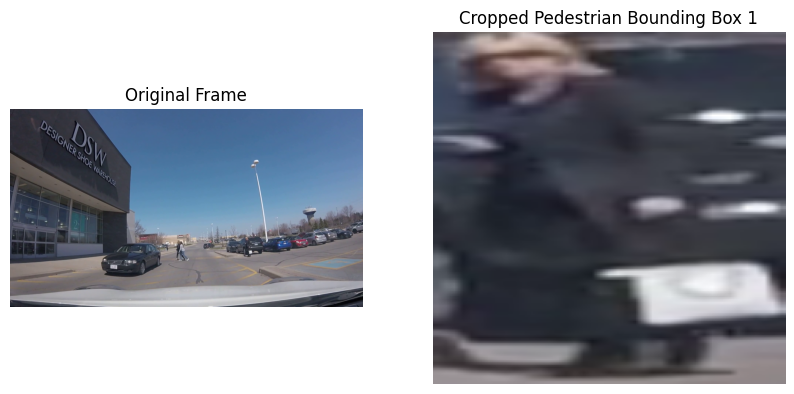

Frame: 18
STN output shape: torch.Size([1, 3, 224, 224])


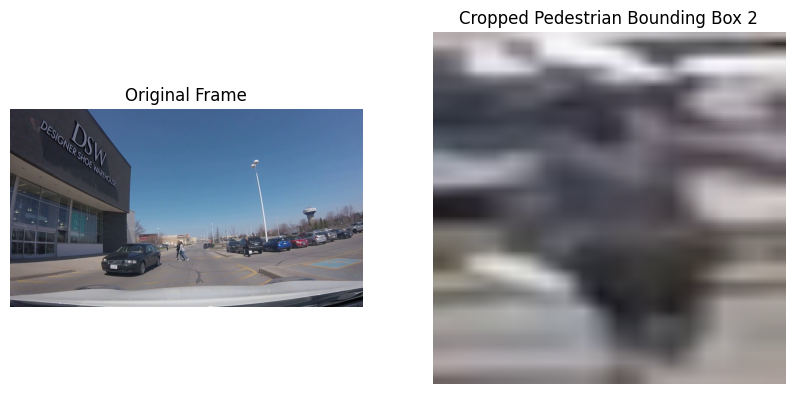

Frame: 18
STN output shape: torch.Size([1, 3, 224, 224])


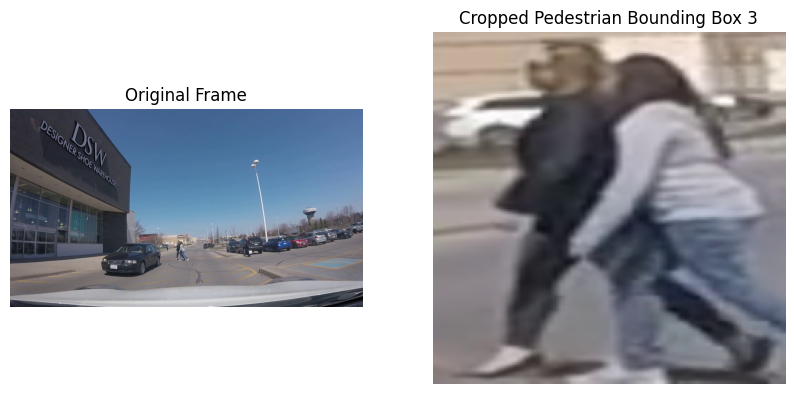

Frame: 18
STN output shape: torch.Size([1, 3, 224, 224])


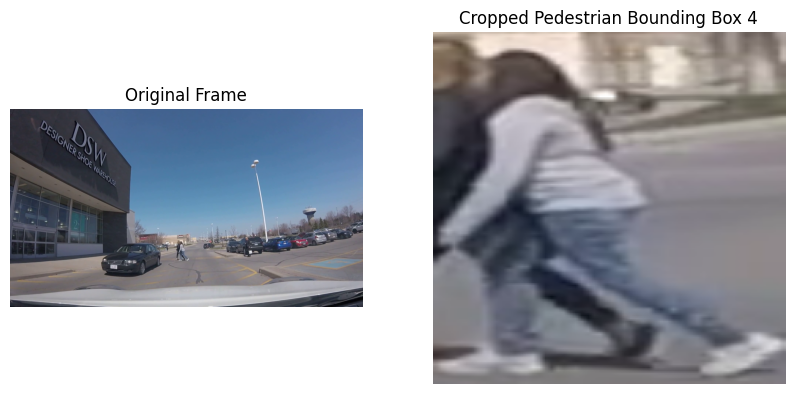

In [63]:
# 으앙 ㅠㅠㅠㅠㅠ 됐다 ㅠㅠㅠㅠㅠㅠㅠ
# STN 모델 성공..ㅠㅠㅠㅠㅠ
# 다수의 보행자가 있으면 다수의 보행자 bounding box를 추출해서 crop
# 근데 화질이 너무 안 좋아서 관련 부분 전처리 해야할 듯

import cv2
import os
import xml.etree.ElementTree as ET
import numpy as np

# Function to parse annotation XML file and extract bounding box coordinates
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extract bounding box coordinates for each frame
    bounding_boxes = []
    for pedestrian in root.findall('.//pedestrian'):
        for frame in pedestrian.findall('frame'):
            bbox_attrib = frame.find('bbox').attrib
            xtl = float(bbox_attrib['xtl'])
            ytl = float(bbox_attrib['ytl'])
            xbr = float(bbox_attrib['xbr'])
            ybr = float(bbox_attrib['ybr'])
            bounding_boxes.append((xtl, ytl, xbr, ybr))

    return bounding_boxes
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extract bounding box coordinates for each frame
    bounding_boxes = {}
    for pedestrian in root.findall('.//pedestrian'):
        for frame in pedestrian.findall('frame'):
            frame_number = int(frame.get('number'))
            bbox_attrib = frame.find('bbox').attrib
            xtl = float(bbox_attrib['xtl'])
            ytl = float(bbox_attrib['ytl'])
            xbr = float(bbox_attrib['xbr'])
            ybr = float(bbox_attrib['ybr'])
            if frame_number not in bounding_boxes:
                bounding_boxes[frame_number] = []
            bounding_boxes[frame_number].append((xtl, ytl, xbr, ybr))

    return bounding_boxes
import torch
import torch.nn as nn
import torch.nn.functional as F

# class STN(nn.Module):
#     def __init__(self):
#         super(STN, self).__init__()

#         # Localization network (for predicting transformation parameters)
#         self.localization = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=7),
#             nn.MaxPool2d(2, stride=2),
#             nn.ReLU(True),
#             nn.Conv2d(8, 10, kernel_size=5),
#             nn.MaxPool2d(2, stride=2),
#             nn.ReLU(True)
#         )

#         # Regressor for predicting transformation parameters
#         self.fc_loc = nn.Sequential(
#             nn.Linear(10 * 3 * 3, 32),
#             nn.ReLU(True),
#             nn.Linear(32, 3 * 2)  # Predicts 2x3 affine matrix
#         )

#         # Initialize the weights/bias with identity transformation
#         self.fc_loc[-1].weight.data.fill_(0)
#         self.fc_loc[-1].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])

#     # Spatial transformer network forward function
#     def stn(self, x):
#         xs = self.localization(x)
#         xs = xs.view(-1, 10 * 3 * 3)
#         theta = self.fc_loc(xs)
#         theta = theta.view(-1, 2, 3)

#         # Grid generator and sampler
#         grid = F.affine_grid(theta, x.size())
#         x = F.grid_sample(x, grid)
#         return x

#     def forward(self, x):
#         # Apply STN to input
#         x = self.stn(x)
#         return x

import xml.etree.ElementTree as ET

class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()

        # Localization network (for predicting transformation parameters)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for predicting transformation parameters
        # self.fc_loc = nn.Sequential(
        #     nn.Linear(10 * 3 * 3, 32),
        #     nn.ReLU(True),
        #     nn.Linear(32, 3 * 2)  # Predicts 2x3 affine matrix
        # )

        self.localization_output_size = self._get_localization_output_size()

        self.fc_loc = nn.Sequential(
            # nn.Linear(10 * ((224 - 6) // 4 - 4) * ((224 - 6) // 4 - 4), 32),  # Adjust input size
            # nn.Linear(10 * 4 * 4, 32),
            nn.Linear(self.localization_output_size, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)  # Predicts 2x3 affine matrix
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[-1].weight.data.fill_(0)
        self.fc_loc[-1].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        # xs = xs.reshape(-1, 10 * 52 * 52)
        # xs = xs.reshape(-1, 10 * 4 * 4)
        xs = xs.reshape(-1, self.localization_output_size)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        # Grid generator and sampler
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    # Method to extract pedestrian bounding box using annotation file
    def extract_bbox(self, frame_number, annotation_file):
        tree = ET.parse(annotation_file)
        root = tree.getroot()

        # Find the frame with the given frame number
        for pedestrian in root.findall('.//pedestrian'):
            for frame in pedestrian.findall('frame'):
                if int(frame.get('number')) == frame_number:
                    bbox_attrib = frame.find('bbox').attrib
                    xtl = float(bbox_attrib['xtl'])
                    ytl = float(bbox_attrib['ytl'])
                    xbr = float(bbox_attrib['xbr'])
                    ybr = float(bbox_attrib['ybr'])
                    return (xtl, ytl, xbr, ybr)

        print(f"Error: Frame {frame_number} not found in annotation file.")
        return None
    def _get_localization_output_size(self):
        # Dummy input to determine the output size of localization network
        input_tensor = torch.zeros(1, 3, 224, 224)
        localization_output = self.localization(input_tensor)
        return localization_output.size(1) * localization_output.size(2) * localization_output.size(3)

    def forward(self, x):
        # Apply STN to input
        x = self.stn(x)
        return x

def crop_bbox(frame, bbox):
    """
    Crop the bounding box from the frame.

    Args:
    - frame (numpy.ndarray): Input frame (image) from which to crop the bounding box.
    - bbox (tuple): Tuple containing the bounding box coordinates (xtl, ytl, xbr, ybr).

    Returns:
    - cropped_bbox (numpy.ndarray): Cropped bounding box from the frame.
    """

    # Extract bounding box coordinates
    xtl, ytl, xbr, ybr = bbox

    # Ensure bounding box coordinates are within frame boundaries
    xtl = max(0, int(xtl))
    ytl = max(0, int(ytl))
    xbr = min(frame.shape[1], int(xbr))
    ybr = min(frame.shape[0], int(ybr))

    # Crop the bounding box from the frame
    cropped_bbox = frame[ytl:ybr, xtl:xbr]

    return cropped_bbox

# Function to apply STN to extract pedestrian bounding box from each frame
def apply_stn(video_path, annotation_path):
    # Load video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Couldn't open video file")
        return

    # Parse annotation file
    annotation_file = os.path.join(annotation_path, os.path.basename(video_path).split('.')[0] + '.xml')
    bounding_boxes = parse_annotation(annotation_file)

    # Initialize STN model and ViViT model (you need to define these)
    stn_model = STN()
    # vivit_model = YourViViTModel()
    frame_number = 0
    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Apply STN to extract pedestrian bounding box
        # Here, we assume stn_model.extract_bbox is the method to extract the bounding box
        pedestrian_bbox = stn_model.extract_bbox(frame_number, annotation_file)
        if pedestrian_bbox is None:
            print(f"No annotation found for frame {frame_number}")
            frame_number += 1
            continue
        # Pass the extracted pedestrian bounding box to ViViT model for action estimation
        # You need to define how to resize/crop the bounding box and pass it to ViViT model
        # Here, we assume crop_bbox is the function to crop the bounding box from the frame
        pedestrian_crop = crop_bbox(frame, pedestrian_bbox)
        pedestrian_crop = cv2.resize(pedestrian_crop, (224, 224))  # Assuming ViViT input size
        pedestrian_crop = np.expand_dims(pedestrian_crop, axis=0)  # Adding batch dimension

        # Forward pass through ViViT model to estimate action
        # action_prediction = vivit_model.predict(pedestrian_crop)
        # print("Action Prediction:", action_prediction)  # Modify based on your output format

        frame_number+=1
    cap.release()



# Example usage
video_path = "videos/video_0027.mp4"
annotation_path = "/content/vivit_labels/"
apply_stn(video_path, annotation_path)



# STN 모델 시각화하는 부분
import matplotlib.pyplot as plt
import random

def test_stn_random_frame(video_path, annotation_path, stn_model):
    # Load video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Couldn't open video file")
        return

    # Parse annotation file
    annotation_file = os.path.join(annotation_path, os.path.basename(video_path).split('.')[0] + '.xml')
    bounding_boxes = parse_annotation(annotation_file)

    # Select a random frame
    frame_number = random.choice(list(bounding_boxes.keys()))

    # Extract the bounding boxes for the selected frame
    pedestrian_bboxes = bounding_boxes[frame_number]

    # Read the selected frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print("Error: Couldn't read frame")
        return

    # Process each pedestrian bounding box in the frame
    for i, pedestrian_bbox in enumerate(pedestrian_bboxes):
        # Apply STN to extract pedestrian bounding box
        pedestrian_crop = crop_bbox(frame, pedestrian_bbox)
        pedestrian_crop = cv2.resize(pedestrian_crop, (224, 224))  # Assuming ViViT input size
        pedestrian_crop = np.expand_dims(pedestrian_crop, axis=0)  # Adding batch dimension

        # Forward pass through STN model
        output = stn_model(torch.tensor(pedestrian_crop).permute(0, 3, 1, 2).float())
        print("Frame:", frame_number)
        print("STN output shape:", output.shape)

        # Visualize original frame and cropped bounding box
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Original Frame")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(pedestrian_crop[0], cv2.COLOR_BGR2RGB))
        plt.title(f"Cropped Pedestrian Bounding Box {i+1}")
        plt.axis('off')

        plt.show()

    cap.release()

# Example usage"
stn_model = STN()
test_stn_random_frame(video_path, annotation_path, stn_model)


